## Scaling Up AutoEncoders

Lets go ahead and take everything we have learned and scale these models up! Nothing too fancy, I just dont like leaving you with a simple MNIST example. So we will do CelebA for fun, and see if we see any noticable difference between a VAE and VQVAE. 

#### Prerequisites

This notebook will barely go into any specific details for this model, I fully assume you have taken a look at the [Intro to Autoencoders](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders) before this!

To do this, we will create some simple modules to build our AutoEncoder

- **DownsampleBlock**: Will take an Image and downsample the spatial dimension by a factor of 2 (using strided convolution)
- **UpsampleBlock**: Will take an Image, Upsample by 2, and then perform convolution that doesn't change the size anymore
- **ResidualBlock**: Stack of Convolutions, activations and normalizations with a residual connection
- **VectorQuantizer**: This will be directly taken from our [VQVAE tutorial](https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Intro_To_AutoEncoders.ipynb)


In [36]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import get_cosine_schedule_with_warmup
from tqdm.auto import tqdm

### Define Upsample, Downsample, Residual Modules

First step is to define all the modules in common between our VAE and VQVAE. For the most part, I just picked things at random for the sizes of the convolutions, but I did add in some **GroupNorm** modules. This is only because this helps in the UNet architectures for denoising diffusion so why not here! Also if you look at the paper for [Group Normalization](https://arxiv.org/pdf/1803.08494) you see it performs pretty close compared to traditional Batch Norm.

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super().__init__()

        ### Stack of Convolutional Blocks ###
        self.conv_block = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"), 
            nn.ReLU(), 
            nn.GroupNorm(8, out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            nn.ReLU()
        )

        # If our input channels is NOT THE SAME as the output channels, Use a convolution to change number of channels #
        if in_channels != out_channels:
            self.conv_identity = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        else:
            self.conv_identity = nn.Identity()

    def forward(self, x):

        return self.conv_identity(x) + self.conv_block(x)
        
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels):

        super().__init__()

        ### Only Downsample by factor of 2, no change in channels ###
        self.down = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.down(x)


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels):
        
        super().__init__()

        ### Only Upsample by factor of 2, no change in channels #
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding="same"),
            nn.ReLU()
        )

    def forward(self, x):
        return self.upsample(x)

### Vector Quantization Module

This portion will only be for the VQVAE model! I will essentially copy paste the **VectorQuantizer** from our [VQVAE tutorial](https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Intro_To_AutoEncoders.ipynb)

In [3]:
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()
        
        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x, efficient=True):

        batch_size = x.shape[0]
        
        ### Bad Implementation That Requires Matrix Expansion ###
        if not efficient:

            # C: Codebook Size, L: Latent Dim
            
            ### Embedding: [C, L] -> [B, C, L]
            emb = self.embedding.weight.unsqueeze(0).repeat(batch_size,1,1)

            ### X: [B, L] -> [B, 1, L]
            x = x.unsqueeze(1)

            ### [B, C]
            distances = torch.sum(((x - emb)**2), dim=-1)

        ### Alternative more Efficient Implementation ###
        else:
            ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

            ### L2: [B, L] -> [B, 1]
            L2 = torch.sum(x**2, dim=1, keepdim=True)

            ### C2: [C, L] -> [C]
            C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

            ### CL: [B,L]@[L,C] -> [B, C]
            CL = x@self.embedding.weight.t()

            ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
            distances = L2 - 2*CL + C2
        
        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(batch_size, self.codebook_size, device=x.device)

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx,closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents 

### Lets Write the Variational AutoEncoder!

The Autoencoder will have a few input arguments (similar to what you would find in a UNet, but I like this structure):
- **in_channels**: Number of channels in our input image.
- **start_dim**: Number of channels in the first convolutional channel expansion
- **dim_mults**: Channel dimension for every model chunk
    - Each encoder chunk in the model will have a **DownsampleBlock** block followed by two **ResidualBlock**
    - Each decoder chunk in the model will have two **ResidualBlock** followed by a **UpsampleBlock**
- **latent_channels**: Number of channels in the compressed image
- **codebook_size**: Only for VQVAE, number of unique codevectors we want

In [4]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, in_channels=3, start_dim=128, dim_mults=(1,2,4), latent_channels=8):

        super().__init__()

        ### Channel Compression for Latents ###
        self.latent_channels = latent_channels

        ### Starting Convolution to start_dim ###
        self.enc_start = nn.Conv2d(in_channels=in_channels, out_channels=start_dim, kernel_size=3, padding="same")

        ### Define Convolutional Encoder: Downsample + 2x Residual ###
        self.encoder = nn.ModuleList()
        for idx, i in enumerate(dim_mults):

            block_input_dim = i * start_dim
            block_output_dim = dim_mults[idx+1] * start_dim if idx != (len(dim_mults) - 1) else i * start_dim
            
            ### Downsample Block ###
            self.encoder.append(
                DownsampleBlock(in_channels=block_input_dim)
            )

            ### Residual Blocks ###
            self.encoder.append(
                ResidualBlock(in_channels=block_input_dim, out_channels=block_input_dim)
            )

            self.encoder.append(
                ResidualBlock(in_channels=block_input_dim, 
                                out_channels=block_output_dim)
            )
        
        self.encoder = nn.Sequential(*self.encoder)

        ### Map to Mu and LogVar for VAE ###
        self.conv_mu = nn.Conv2d(in_channels=start_dim*dim_mults[-1],
                                 out_channels=self.latent_channels, 
                                 kernel_size=3, 
                                 padding="same")

        self.conv_logvar = nn.Conv2d(in_channels=start_dim*dim_mults[-1],
                                     out_channels=self.latent_channels, 
                                     kernel_size=3, 
                                     padding="same")

        ### Define Convolutional Decoder ###

        ### Starting the Decoder Back to High Dimensional Channels
        self.dec_start = nn.Conv2d(in_channels=self.latent_channels, 
                                   out_channels=start_dim*dim_mults[-1],
                                   kernel_size=3,
                                   padding="same")


        ### Create the Remaining Decoder Blocks going 2xResidual + Upsample ###
        self.decoder = nn.ModuleList()
        dim_mults = dim_mults[::-1]
        for idx, i in enumerate(dim_mults):
            block_input_dim = i*start_dim
            block_output_dim = dim_mults[idx+1] * start_dim if idx != (len(dim_mults) - 1) else i * start_dim

            ### Residual Blocks ###
            self.decoder.append(
                ResidualBlock(in_channels=block_input_dim, out_channels=block_input_dim)
            )

            self.decoder.append(
                ResidualBlock(in_channels=block_input_dim, 
                                out_channels=block_output_dim)
            )
            
            ### Upsample Block ###
            self.decoder.append(
                UpsampleBlock(in_channels=block_output_dim)
            )

        ### Add a Sigmoid to Map values btwn 0 and 1 ###
        self.decoder = nn.Sequential(*self.decoder)

        ### Map Back to Image Space and Map to Range [0,1] ###
        self.final_mapping = nn.Sequential(
            nn.Conv2d(in_channels=start_dim*dim_mults[-1], 
                      out_channels=in_channels, 
                      kernel_size=3, 
                      padding="same"), 

            nn.Sigmoid()
        )

            
    def encode(self, x):

        ### Starting Encoder Convolution ###
        x = self.enc_start(x)
        
        ### Pass through Encoder ###
        conv_enc = self.encoder(x)

        ### Get Mu and Sigma ###
        mu = self.conv_mu(conv_enc)
        logvar = self.conv_logvar(conv_enc)

        ### Sample with Reparamaterization Trick ###
        sigma = torch.exp(0.5*logvar)
        noise = torch.randn_like(sigma, device=sigma.device)
        z = mu + sigma*noise

        return z, mu, logvar

    def decode(self, x):

        ### Starting Decoder Convolution ###
        x = self.dec_start(x)

        ### Pass through Decoder ###
        x = self.decoder(x)

        ### Map Back to Pixel Space ###
        x = self.final_mapping(x)
        
        return x
        
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        decoded = self.decode(z)
        return z, decoded, mu, logvar

### Variational AutoEncoder Loss Function

This is the loss we had from our previous tutorial! So lets add that in because we need it!

In [6]:
def VAELoss(x, x_hat, mean, log_var, kl_weight=1, reconstruction_weight=1):

    ### Compute the MSE For Every Pixel [B, C, H, W] ###
    pixel_mse = ((x-x_hat)**2)

    ### Flatten Each Image in Batch to Vector [B, C*H*W] ###
    pixel_mse = pixel_mse.flatten(1)

    ### Sum  Up Pixel Loss Per Image and Average Across Batch ###
    reconstruction_loss = pixel_mse.sum(axis=-1).mean()

    ### Compute KL Per Image and Sum Across Flattened Latent###
    kl = (1 + log_var - mean**2 - torch.exp(log_var)).flatten(1)
    kl_per_image = - 0.5 * torch.sum(kl, dim=-1)

    ### Average KL Across the Batch ###
    kl_loss = torch.mean(kl_per_image)
    
    return reconstruction_weight*reconstruction_loss + kl_weight*kl_loss
    

### Lets Write the Vector Quantized Variational AutoEncoder!

Almost identical to our VAE, but we will add in our quantization module, and then compute our commitment and codebook losses

In [7]:
class ConvolutionalVQVAE(nn.Module):
    def __init__(self, in_channels=3, start_dim=128, dim_mults=(1,2,4), 
                 latent_channels=8, codebook_size=512):

        super().__init__()

        ### Channel Compression for Latents ###
        self.latent_channels = latent_channels

        ### Starting Convolution to start_dim ###
        self.enc_start = nn.Conv2d(in_channels=in_channels, out_channels=start_dim, kernel_size=3, padding="same")

        ### Define Convolutional Encoder: Downsample + 2x Residual ###
        self.encoder = nn.ModuleList()
        for idx, i in enumerate(dim_mults):

            block_input_dim = i * start_dim
            block_output_dim = dim_mults[idx+1] * start_dim if idx != (len(dim_mults) - 1) else i * start_dim
            
            ### Downsample Block ###
            self.encoder.append(
                DownsampleBlock(in_channels=block_input_dim)
            )

            ### Residual Blocks ###
            self.encoder.append(
                ResidualBlock(in_channels=block_input_dim, out_channels=block_input_dim)
            )

            self.encoder.append(
                ResidualBlock(in_channels=block_input_dim, 
                                out_channels=block_output_dim)
            )
        
        self.encoder = nn.Sequential(*self.encoder)


        ### Bottleneck + Vector Quantization Module ###

        self.pre_vq_conv = nn.Conv2d(in_channels=start_dim*dim_mults[-1], 
                                     out_channels=latent_channels,
                                     kernel_size=3, 
                                     padding="same")
        
        self.vq = VectorQuantizer(codebook_size=codebook_size,
                                  latent_dim=latent_channels)

        
        ### Define Convolutional Decoder ###

        ### Starting the Decoder Back to High Dimensional Channels
        self.dec_start = nn.Conv2d(in_channels=self.latent_channels, 
                                   out_channels=start_dim*dim_mults[-1],
                                   kernel_size=3,
                                   padding="same")


        ### Create the Remaining Decoder Blocks going 2xResidual + Upsample ###
        self.decoder = nn.ModuleList()
        dim_mults = dim_mults[::-1]
        for idx, i in enumerate(dim_mults):
            block_input_dim = i*start_dim
            block_output_dim = dim_mults[idx+1] * start_dim if idx != (len(dim_mults) - 1) else i * start_dim

            ### Residual Blocks ###
            self.decoder.append(
                ResidualBlock(in_channels=block_input_dim, out_channels=block_input_dim)
            )

            self.decoder.append(
                ResidualBlock(in_channels=block_input_dim, 
                                out_channels=block_output_dim)
            )
            
            ### Upsample Block ###
            self.decoder.append(
                UpsampleBlock(in_channels=block_output_dim)
            )

        ### Add a Sigmoid to Map values btwn 0 and 1 ###
        self.decoder = nn.Sequential(*self.decoder)

        ### Map Back to Image Space and Map to Range [0,1] ###
        self.final_mapping = nn.Sequential(
            nn.Conv2d(in_channels=start_dim*dim_mults[-1], 
                      out_channels=in_channels, 
                      kernel_size=3, 
                      padding="same"), 

            nn.Sigmoid()
        )

            
    def encode(self, x):

        ### Starting Encoder Convolution ###
        x = self.enc_start(x)
        
        ### Pass through Encoder ###
        conv_enc = self.encoder(x)
        
        ### Pass Through Pre Vector Quantize Conv BottleNeck ###
        conv_enc = self.pre_vq_conv(conv_enc)

        return conv_enc

    def quantize(self, z):

        ### Quantize Z ###
        codes = self.vq(z)

        ### Compute VQ Loss ###
        codebook_loss = torch.mean((codes - z.detach())**2)
        commitment_loss = torch.mean((codes.detach() - z)**2)

        ### Straight Through (Copy Gradients) ###
        codes = z + (codes - z).detach()

        return codes, codebook_loss, commitment_loss

    def decode(self, x):

        batch_size, channels, height, width = x.shape

        ### Reshape x for Quantization ###
        x = x.permute(0,2,3,1)
        x = torch.flatten(x, start_dim=0, end_dim=-2)

        ### Quantize Data ###
        codes, codebook_loss, commitment_loss = self.quantize(x)

        ### Reshape Back to B x C x H x W ###
        codes = codes.reshape(batch_size, height, width, channels)
        codes = codes.permute(0,3,1,2)

        ### Starting Decoder Convolution ###
        conv_dec = self.dec_start(codes)

        ### Pass through Decoder ###
        conv_dec = self.decoder(conv_dec)

        ### Map Back to Pixel Space ###
        conv_dec = self.final_mapping(conv_dec)
        
        return codes, conv_dec, codebook_loss, commitment_loss
        
    def forward(self, x):
        latents = self.encode(x)
        quantized_latents, decoded, codebook_loss, commitment_loss = self.decode(latents)
        return latents, quantized_latents, decoded, codebook_loss, commitment_loss

### Moving to Separate Scripts

At this point, we have built our different models, but I want to train these in a distributed environment. I typically use [Accelerate](https://huggingface.co/docs/accelerate/en/index) for this and prefer running these from python scripts. Becuase the training loops are slightly different for each model, I have created two training scripts:

- train_vae.py
- train_vqvae.py

Everything is identical to what we already wrote, just with a simple training script (with the respective loss function for each model) and everything wrapped in Accelerate. I have already trained the models, so lets took a look at the output!

### Visualizing Outputs of Models 

All we need to do is load our dataset, the two models we have and then plot the reconstructions to see if we have any improvements from our VQVAE over the VAE!

If you want to try the models yourself, without training the models, you can download the model weights [here](https://drive.google.com/drive/folders/1BLF8CjdzwO6AEm8-6ktif1LNP9Ch_mXR?usp=sharing) and then just update the paths to the models in *load_state_dict*!

VAE Number of Params 34391443
VQVAE Number of Params 34358667


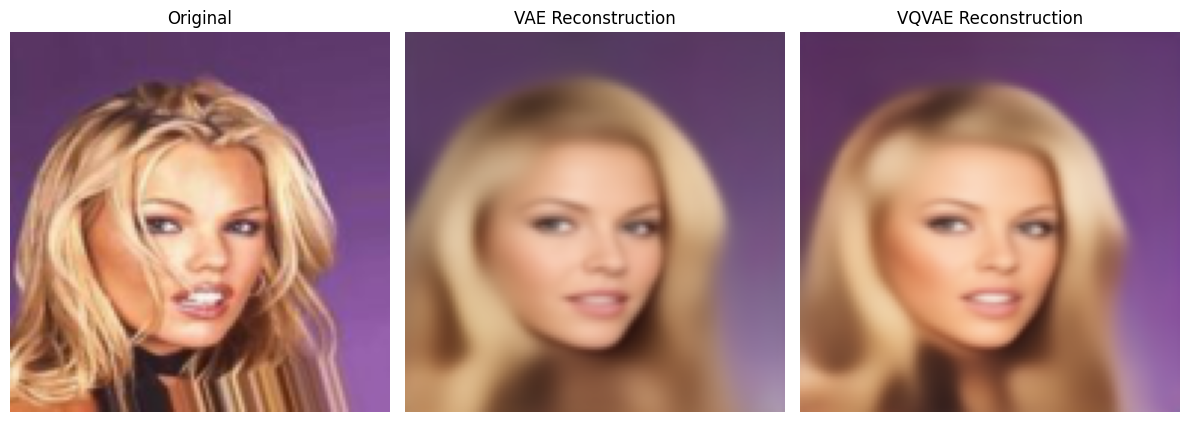

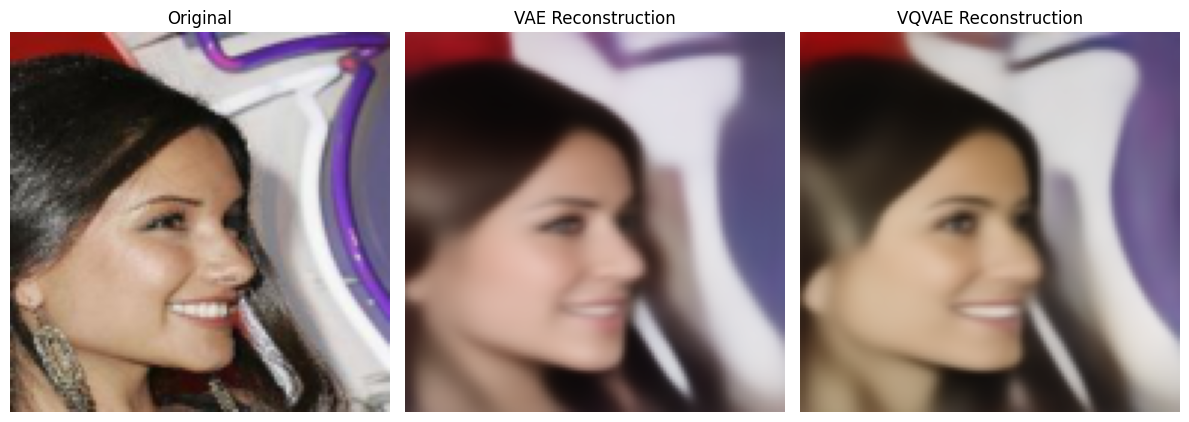

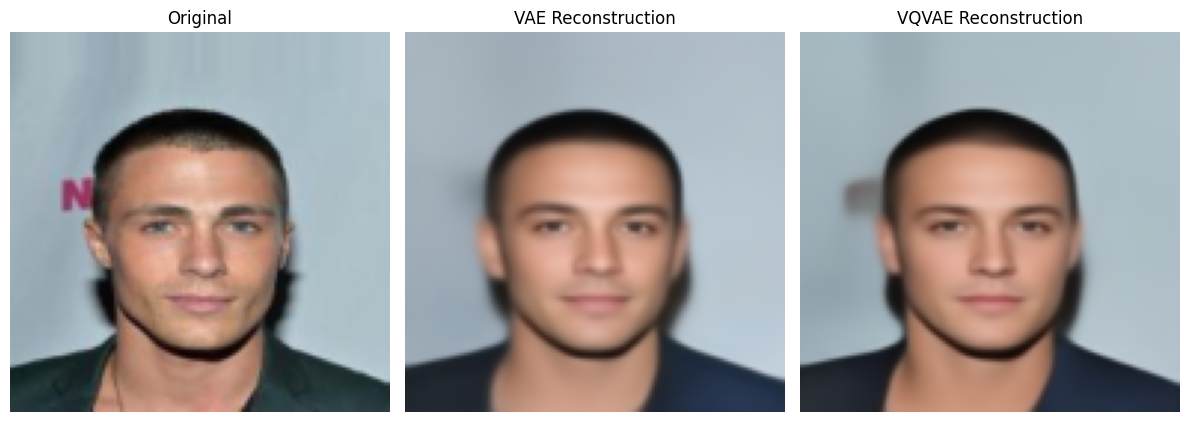

In [49]:
### DEFINE DATASET ###

img_transforms = transforms.Compose(
    [
        transforms.Resize((128,128)), 
        transforms.ToTensor(),
    ]
)

dataset = ImageFolder("../../../data/CelebA/", transform=img_transforms)


### LOAD MODELS ###
vae = ConvolutionalVAE(start_dim=128, dim_mults=(1,2,2,4), latent_channels=8)
vae.load_state_dict(torch.load("work_dir/vae/best_vae/pytorch_model.bin"))

vqvae = ConvolutionalVQVAE(start_dim=128, dim_mults=(1,2,2,4), latent_channels=8)
vqvae.load_state_dict(torch.load("work_dir/vqvae/best_vqvae/pytorch_model.bin"))

print("VAE Number of Params", sum(p.numel() for p in vae.parameters() if p.requires_grad))
print("VQVAE Number of Params", sum(p.numel() for p in vqvae.parameters() if p.requires_grad))

### PLOT RECONSTRUCTIONS ###
image_index = 0

def plot_reconstruction(image_index):

    ### Grab Image ###
    image, _ = dataset[image_index]
    image = image.unsqueeze(0)

    ### Inference Models ###
    with torch.no_grad():
        _, conv_vae_reconstructed, _, _ = vae(image)
    conv_vae_reconstructed = conv_vae_reconstructed.squeeze().permute(1,2,0).numpy()

    with torch.no_grad():
        _, _, decoded, _, _ = vqvae(image)
    conv_vqvae_reconstructed = decoded.squeeze().permute(1,2,0).numpy()


    fig, ax = plt.subplots(1,3, figsize=(12,5))
    ax[0].imshow(image.squeeze().permute(1,2,0).numpy())
    ax[0].set_title("Original")
    ax[1].imshow(conv_vae_reconstructed, cmap="gray")
    ax[1].set_title("VAE Reconstruction")
    ax[2].imshow(conv_vqvae_reconstructed, cmap="gray")
    ax[2].set_title("VQVAE Reconstruction")

    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.axis("off")

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()


for i in random.sample(list(range(200000)), 3):
    plot_reconstruction(i)

The difference is pretty subtle, but if you randomly generate images, you will see that more often than not the VAE looks more blurry compared to the VQVAE. Im sure if I trained the models longer we would see even better results, but for now this shoul de sufficient to atleast convince to you that there is some visual benefit of quantization!

One thing to keep in mind though, the reconstruction loss for both of these models were Mean Squared Error, but this really isn't a perceptual loss function. To improve upon this, we can add a GAN loss, which will be coming up as one of our next steps!